# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$.
    
- Its density can be explicilty evaluated using the inverse transformation:
    $$
    \forall \theta \in \mathbb{R}^m, \quad q_{\phi}(\theta \mid x) = p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|
    $$
    which means that flow can be trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$

- We can sample from it using the forward transformation:
    $$z_i\sim p(z) = \mathcal{N}(0,\mathbf{1}_m) \quad \rightarrow \quad \theta^{\phi; x}_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x)$$
**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution. 

Using the same definition for $q_{\phi}$ as during sampling, $q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$ (c.f. $T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x)$ for $z\sim p(z)$), we have:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N_2$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N_2}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train classifier** to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - **features** $[Z_i, x_i]$
    - **labels**: $Y = 0$, if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $\quad Y=1$, if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate consistency** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We evaluate the distribution of the predictive probability of belonging to class $0$ (normal distribution) $\hat{p}(Y=0\mid z,x_0)$ for $z\sim \mathcal{N}(0,\mathbf{1}_m)$ and fixed $x=x_0$: 
        - draw $z_i \sim \mathcal{N}(0,\mathbf{1}_m), i \in [1,N]$, 
        - evaluate the predictive probability of the trained classifier in the features $[z_i, x_0]$ (e.g. with the function `predict_proba` for `scikit-learn`-classifiers), 
        - ouput: a vector of samples $[\hat{p}(Y=0\mid z_1,x_0), \dots, \hat{p}(Y=0\mid z_N,x_0)]$ from the wanted distribution.
    
    - Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a **dirac around $0.5$** (will be larger if not enough training samples, as unlikely datapoints that would not be covered by the training dataset could be considered out-of-distribution). 
    - Visualization:
        - histograms
        - PP-plots: c.d.f of the predicted probas vs. c.d.f of the dirac (step function)
    - Test statistics: 
        - euclidean distance between c.d.fs of predicted probas and dirac (step function)
        - wasserstein distance between dirac and predicted probas 

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- how to interpret the pp-plots of the predicted probabilities: what deviances from dirac indicate bias/dispersion? 

## Numerical illustration

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

In [2]:
from data.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0,0], sigma=[1,1], rho=0.8)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = 'saved_experiments/Gaussian1d_localPIT/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)

NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


### Density Estimation
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

We will see that the global consistency check (on average over $x$-space, and not locally at a specific location $x=x_0$) is insensitive to the covariate transforms in $x$-space: Both estimators pass the test. 

The local consistency test however will show that the bad MAF is actually not a good approximation of the target density when evaluated at some fixed location $x=x_0$.

In [3]:
from nde.flows import construct_maf
from nde.train import train
from data.feature_transforms import first_dim_only, identity

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=True, num_layers=5
)

# ... trained on X=(X_1,X_2)
filename = 'saved_experiments/Gaussian1d_localPIT/maf_good.pkl'
if os.path.exists(filename):
    maf_good = torch.load(filename)
else:
    _, _ = train(
        maf_good,
        theta_train,
        context=x_train,  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=True, num_layers=5
)

# ... trained on g(X)=(X_1)
g = first_dim_only
filename = 'saved_experiments/Gaussian1d_localPIT/maf_bad.pkl'
if os.path.exists(filename):
    maf_bad = torch.load(filename)
else:
    _, _ = train(
        maf_bad,
        theta_train,
        context=g(x_train),  # g(X)=(X_1)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

torch.save(maf_good, 'saved_experiments/Gaussian1d_localPIT/maf_good.pkl')
torch.save(maf_bad, 'saved_experiments/Gaussian1d_localPIT/maf_bad.pkl')

### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [4]:
# Compute the inverse flow transformation on samples from the calibration set 
inv_flow_samples_cal_good = maf_good._transform(theta_cal, context=x_cal)[0].detach().numpy()
inv_flow_samples_cal_bad = maf_bad._transform(theta_cal, context=first_dim_only(x_cal))[0].detach().numpy()

# Generate data from the base / normal distribution 
from scipy.stats import norm
norm_samples = norm().rvs(cal_size)

#### 1. Global Consistency Check
We start by looking at the overall performance of our estimators: c2st score (i.e. cross-val accuracy) for a discrimination task between the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$ over the joint, and $\mathcal{N}(0,1)$. This gives us the expected performance over the $x$-space, and not for a specific location $x_0$. 

In [5]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good = c2st_scores(torch.tensor(inv_flow_samples_cal_good), torch.tensor(norm_samples[:,None]), n_folds=10)
scores_bad = c2st_scores(torch.tensor(inv_flow_samples_cal_bad), torch.tensor(norm_samples[:,None]), n_folds=10)
print('good:', np.mean(scores_good).__round__(2), '+/-', np.std(scores_good).__round__(2))
print('bad:', np.mean(scores_bad).__round__(2), '+/-', np.std(scores_bad).__round__(2))

good: 0.5 +/- 0.01
bad: 0.51 +/- 0.02


Both estimators (good and bad) show good average performance! 

#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

In [5]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_test))]
).reshape(-1, 1)

#### True and estimated densities at $x_0$

/data/parietal/store/work/jlinhart/git_repos/valDiags_flows/plot.py:12: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/RangeFactories.cpp:20.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1, 1)


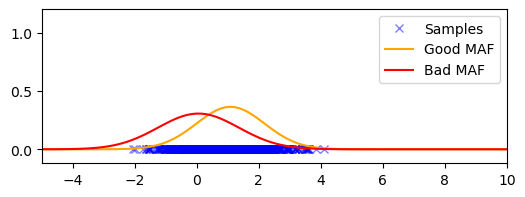

In [6]:
from plot import plot_pdf_1D
from diagnostics.pp_plots import PP_plot_1D, cde_pit_values

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


- bad maf: negative bias and a little overdispersed
- good maf: seems fine, just a little positive bias.

#### Local C2ST at $x_0$

##### Predict probas at $x_0$ 

In [9]:
# train classifier and predict probas for x_0
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st

n_trials = 2
probas_good = []
probas_bad = []
probas_null = []
for t in range(n_trials): 
        # good and bad maf 
        # train classifiers 
        clf_good = local_flow_c2st(inv_flow_samples_cal_good, x_cal)
        clf_bad = local_flow_c2st(inv_flow_samples_cal_bad, x_cal)
        # predict probas 
        probas_good.append(eval_local_flow_c2st(clf_good, x_0[0], dim=1, n_rounds=1000))
        probas_bad.append(eval_local_flow_c2st(clf_bad, x_0[0], dim=1, n_rounds=1000))

        # null hypothesis
        # train classifier
        clf_null = local_flow_c2st(norm_samples[:,None], x_cal)
        # predict probas
        probas_null.append(eval_local_flow_c2st(clf_null, x_0[0], dim=1, n_rounds=1000))

In [19]:
# Load pre-computed results 
n_trials = 1000
filename_good = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_good.pkl'
filename_bad = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_bad.pkl'
filename_null = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_null.pkl'

if os.path.exists(filename_good):
    probas_good = torch.load(filename_good)
if os.path.exists(filename_bad):
    probas_bad = torch.load(filename_bad)

if os.path.exists(filename_bad):
    probas_null = torch.load(filename_null)
    

##### Plot histograms 

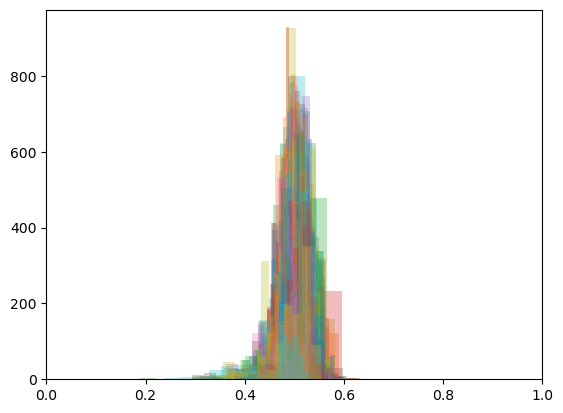

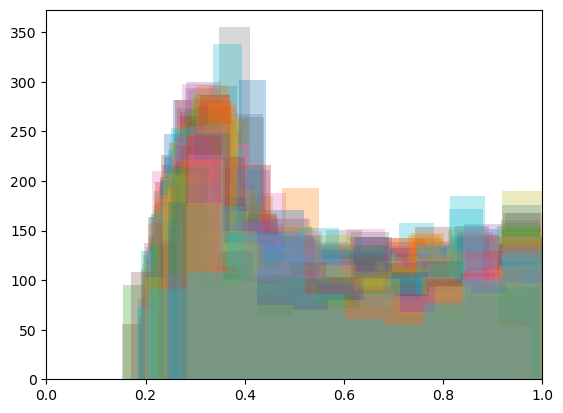

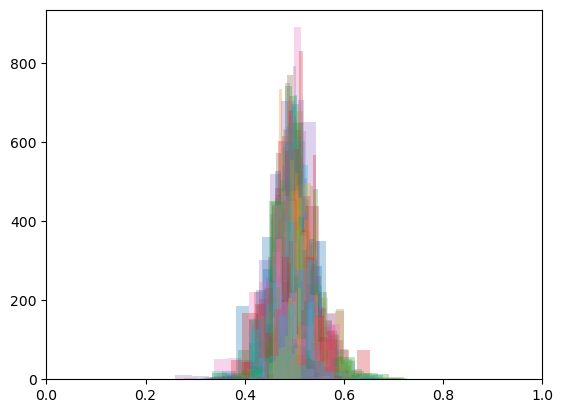

In [11]:
n_trials = 1000

for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

1. Distribution (c.d.f.) of predicted probas 

The associated test-statistic is the euclidean distance to the dirac function at $0.5$ (black dashed line).

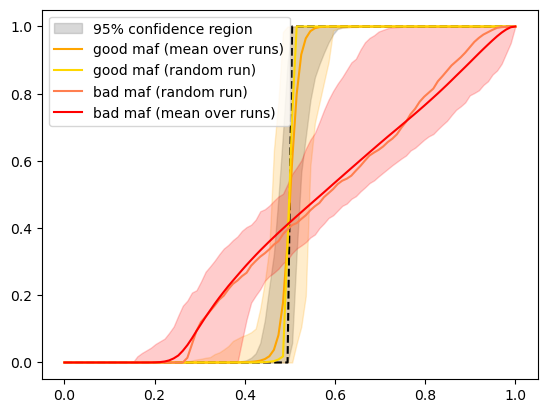

Test statistics and p-values for the chosen random run:

test stat good :  0.00200237
p-value good :  0.92

test stat bad :  0.07265400999999999
p-value bad :  0.0


In [22]:
from diagnostics.pp_plots import PP_vals

random_run_idx = np.random.randint(0,1000)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
plt.plot(alphas, pp_vals_dirac, '--', color='black')

pp_vals_null = {}
test_stats_null = {}
for t in range(len(probas_null)):
    pp_vals_null[t] = pd.Series(PP_vals(probas_null[t], alphas))
    test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

pp_vals_good = {}
pp_vals_bad = {}
test_stats_good = {}
test_stats_bad = {}
for t in range(len(probas_null)):
    pp_vals_good[t] = pd.Series(PP_vals(probas_good[t], alphas))
    pp_vals_bad[t] = pd.Series(PP_vals(probas_bad[t], alphas))
    test_stats_good[t] = ((pp_vals_good[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
    test_stats_bad[t] = ((pp_vals_bad[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
plt.fill_between(alphas, low_null, up_null, color="grey", alpha=0.3, label='95% confidence region')

low_good = pd.DataFrame(pp_vals_good).min(axis=1)
up_good = pd.DataFrame(pp_vals_good).max(axis=1)
line_good = pd.DataFrame(pp_vals_good).mean(axis=1)
plt.plot(alphas, line_good, label='good maf (mean over runs)', color='orange')
plt.plot(alphas, pp_vals_good[random_run_idx], color='gold', label='good maf (random run)')
plt.fill_between(alphas, low_good, up_good, color="orange", alpha=0.2)

low_bad = pd.DataFrame(pp_vals_bad).min(axis=1)
up_bad = pd.DataFrame(pp_vals_bad).max(axis=1)
line_bad = pd.DataFrame(pp_vals_bad).mean(axis=1)
plt.plot(alphas, pp_vals_bad[random_run_idx], color='coral', label='bad maf (random run)')
plt.plot(alphas, line_bad, label='bad maf (mean over runs)', color='red')
plt.fill_between(alphas, low_bad, up_bad, color="red", alpha=0.2)
plt.legend()
plt.show()


# Test statistics and p-values for the chosen random run 
print('Test statistics and p-values for the chosen random run:')
print()
test_stat_good = ((pp_vals_good[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_good = sum(1 * (test_stat_good < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat good : ', test_stat_good)
print('p-value good : ', p_value_good)
print()

test_stat_bad = ((pp_vals_bad[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_bad = sum(1 * (test_stat_bad < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat bad : ', test_stat_bad)
print('p-value bad : ', p_value_bad)

2. Wasserstein distance between dirac and predicted probas for class 0

This metric was introduced because we found that in some cases (c.f. `JRNMM.ipynb`) where the confidence region is quite large the distance to the heaviside step function is maybe not the best: even under the null hypothesis values can get high (e.g. higher than for the uniform distribution that will thus not be rejected) as the discontinuity will yield several values will be at or close to the max distance of 1.

In [23]:
from scipy.stats import wasserstein_distance
w_dist_good = [wasserstein_distance([0.5]*1000, probas_good[t]) for t in range(1000)]
w_dist_bad = [wasserstein_distance([0.5]*1000, probas_bad[t]) for t in range(1000)]
w_dist_null = [wasserstein_distance([0.5]*1000, probas_null[t]) for t in range(1000)]

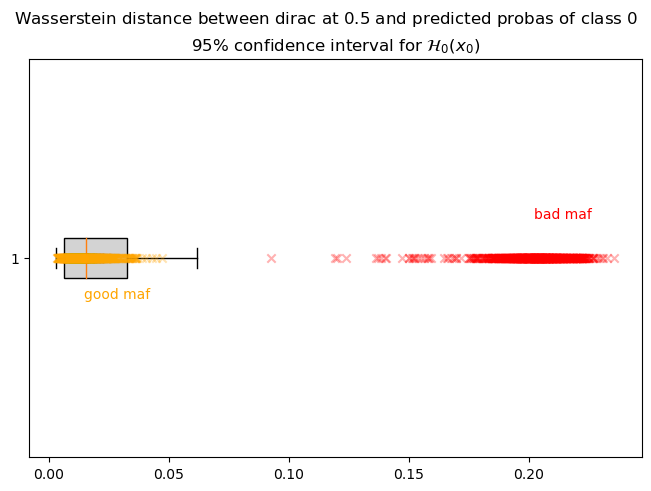

Test statistics and p-values for the chosen random run:

good maf:
test stat:  0.006923394943678841
p_value:  0.93
bad maf:
test stat:  0.19496607966866103
p_value:  0.0


In [24]:
import matplotlib.cbook as cbook

data = w_dist_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(w_dist_good), 0.9, 'good maf', color='orange')
plt.scatter(np.mean(w_dist_good), 1, color='orange', zorder=10)
for a in w_dist_good:
    plt.scatter(a, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(w_dist_bad), 1.1, 'bad maf', color='red')
plt.scatter(np.mean(w_dist_bad), 1, color='red')
for a in w_dist_bad:
    plt.scatter(a, 1, marker='x', color='red', zorder=11, alpha=0.3)

p_value_good = sum(1 * (w_dist_good[random_run_idx] < pd.Series(w_dist_null))) / len(w_dist_null)
p_value_bad = sum(1 * (w_dist_bad[random_run_idx] < pd.Series(w_dist_null))) / len(w_dist_null)

# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x_0)$')
plt.suptitle(r'Wasserstein distance between dirac at $0.5$ and predicted probas of class 0')
plt.show()
print('Test statistics and p-values for the chosen random run:')
print()
print('good maf:')
print('test stat: ', w_dist_good[random_run_idx])
print('p_value: ', p_value_good)
print('bad maf:')
print('test stat: ', w_dist_bad[random_run_idx])
print('p_value: ', p_value_bad)

### Choice of classification model cal-set size

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import torch.distributions as D
import time

#### Accuracy - Shift experiment - Model choice
We compute the global cross-val c2st accuracy score between two 1D gaussians: 
- Reference: $\quad \mathcal{N}(0,1)$
- Gaussian with shifted mean or std: $\quad \mathcal{N}(m,1), m \in [0,10] \quad$ or $\quad \mathcal{N}(0,s), s \in [1,20]$

The classifiers are trained on samples of the joint: $[z_i, x_i]$ where the $z_i$ correspond to samples from the reference or the other gaussian distribution with lables 0 or 1.

We can also look at the total cv time.

##### Experimental SET-UP

In [8]:
def eval_clf_local_c2st(x_samples, ref_samples, shifted_samples, shifts, clf_class, clf_kwargs, nfolds=10):
    ref_joint_samples = torch.cat([ref_samples,x_samples], dim=1)
    shift_list = []
    scores = []
    times = []
    for s_samples,s in zip(shifted_samples, shifts):
        s_joint_samples = torch.cat([s_samples, x_samples], axis=1)
        start = time.time()
        cross_val_scores = c2st_scores(ref_joint_samples, s_joint_samples, n_folds=nfolds, clf_class=clf_class, clf_kwargs=clf_kwargs)
        total_cv_time = time.time() - start
        for t in range(nfolds):
            shift_list.append(s)
            scores.append(cross_val_scores[t])
            times.append(total_cv_time)
    return shift_list, scores, times

In [9]:
N_list = [1000, 2000, 5000]
mean_shifts = [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 5, 10]
scale_shifts = np.linspace(1, 20, 10)

# Datasets
x_samples = {}
ref_samples = {}
for n in N_list:
    x_samples[n] = data_gen.sample_x(n)
    ref_samples[n] = D.MultivariateNormal(
        loc=torch.zeros(1), covariance_matrix=torch.eye(1)
    ).rsample((n,))

mean_shifted_samples = {}
scale_shifted_samples = {}
for n in N_list:
    mean_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)
        ).rsample((n,))
        for m in mean_shifts
    ]
    scale_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.zeros(1), covariance_matrix=torch.eye(1) * s
        ).rsample((n,))
        for s in scale_shifts
    ]

# Models
ndim = x_samples[1000].shape[-1] + ref_samples[1000].shape[-1]
clf_classes = {
    "mlp_base": MLPClassifier,
    "mlp_sbi": MLPClassifier,
    "rf": RandomForestClassifier,
    "logreg": LogisticRegression,
    "lda": LinearDiscriminantAnalysis,
    "qda": QuadraticDiscriminantAnalysis,
}
clf_kwargs_dict = {
    "mlp_base": {},
    "mlp_sbi": {
        "activation": "relu",
        "hidden_layer_sizes": (10 * ndim, 10 * ndim),
        "max_iter": 1000,
        "solver": "adam",
        "early_stopping": True,
        "n_iter_no_change": 50,
    },
    "rf": {},
    "logreg": {},
    "lda": {},
    "qda": {},
}



##### Mean shifts

In [50]:
clf_names = ["mlp_sbi", "rf", "lda", "logreg"]

filename = 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl'
if os.path.exists(filename):
    dfs_mean = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl')
    for n in N_list:
        dfs_mean[n] = dfs_mean[n][dfs_mean[n]['classifier'].isin(clf_names)]
else:
    dfs_mean = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_clf_local_c2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=mean_shifted_samples[n],
                shifts=mean_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'mean_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_mean[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_mean, 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl')


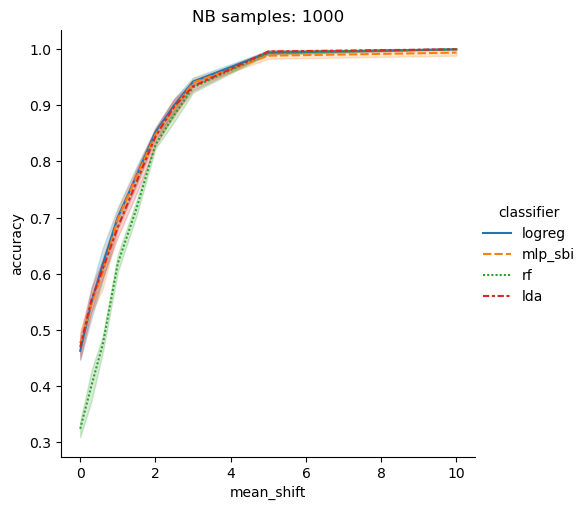

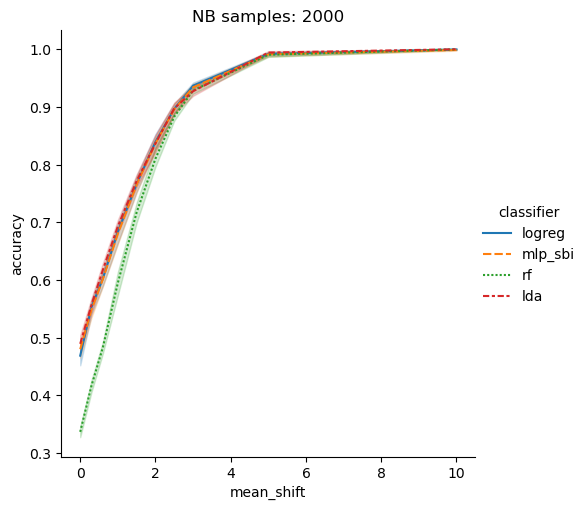

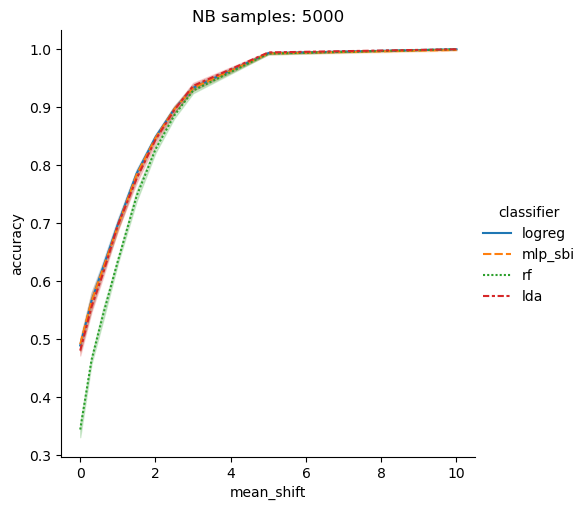

In [51]:
import seaborn as sns
for n in N_list:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale Shifts

In [52]:
clf_names = ["mlp_sbi", "rf", "qda", "logreg"]

filename = 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl'
if os.path.exists(filename):
    dfs_scale = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl')
    for n in N_list:
        dfs_scale[n] = dfs_scale[n][dfs_scale[n]['classifier'].isin(clf_names)]
else:
    dfs_scale = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_clf_local_c2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=scale_shifted_samples[n],
                shifts=scale_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'scale_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_scale[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_scale, 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl')

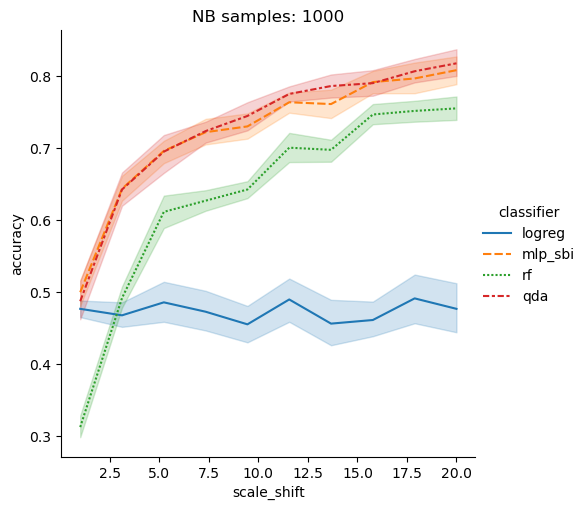

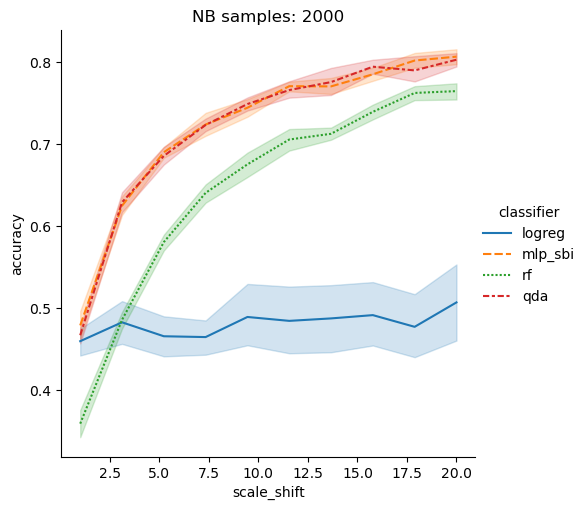

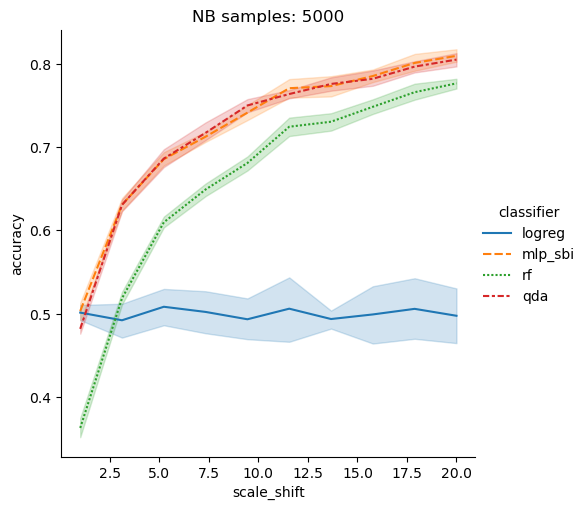

In [53]:
for n in N_list:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

We coose the MLP classifier (for this example the mlp_base seems to be enough, we still chose the default mlp from `sbi.utils.metrics`)

#### Precision under the null hypothesis - cal set size 

For different cal set sizes we compute the cross-val test statistics (distance to dirac c.d.f) and stds of the predicted distribution (output of `eval_local_flow_c2st`) under the null hypothesis.

We relax the problem from a dirac to a gaussian distribution with std of 0.05 or 0.1 (smooth dirac):
- we compute the theoretical test-statistics of those two gaussians 
- we compare the obtained test-statistics and stds of the cross-validation to these theoretical values

##### Theoretical Test-stats for chosen stds

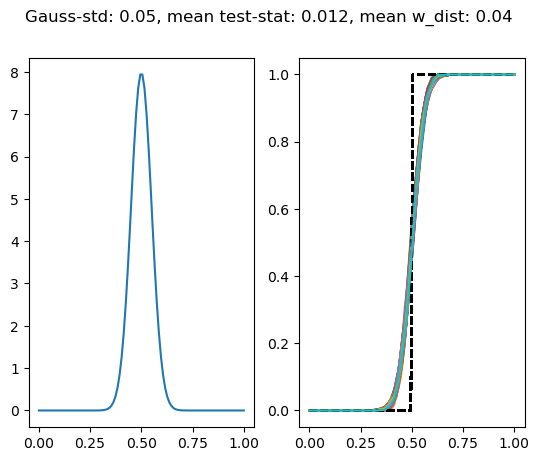

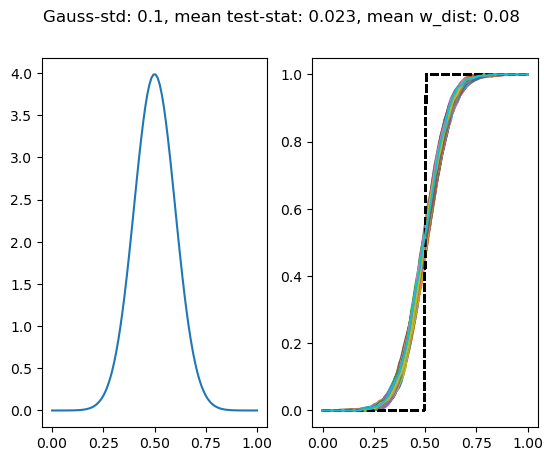

In [20]:
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

def smooth_dirac(eps=0.1):
    return norm(loc=0.5,scale=eps)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
for e in [0.05, 0.1]:
    fig, axs = plt.subplots(1,2)
    axs[0].plot(alphas,[smooth_dirac(eps=e).pdf(x) for x in alphas])

    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    test_stats = []
    w_dist = []
    for t in range(1000):
        samples = smooth_dirac(eps=e).rvs(1000)
        pp_vals = pd.Series(PP_vals(samples, alphas))
        test_stats.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, samples))
        axs[1].plot(alphas, pp_vals_dirac, '--', color='black')
        axs[1].plot(alphas, pp_vals)
    plt.suptitle(f'Gauss-std: {e}, mean test-stat: {np.round(np.mean(test_stats),3)}, mean w_dist: {np.round(np.mean(w_dist),3)}')
    plt.show()

##### Experimental SETUP

In [25]:
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st
from sklearn.model_selection import KFold

def eval_clf_null(x_samples, dim=1, n_list=[1000], classifiers=['mlp'], n_trials=100):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    nb_samples = []
    probas_stds = []
    test_stats = []
    times = []
    clf_method = []

    for n in n_list:
        Q = D.MultivariateNormal(loc=torch.FloatTensor([0]*dim), covariance_matrix=torch.eye(dim)).rsample((n,))
        kf = KFold(n_splits=n_trials, shuffle=True, random_state=1)
        for clf_name in classifiers:
            start = time.time()
            for t, (train_index, test_index) in enumerate(kf.split(x_samples[n])):
                x_samples_train = x_samples[n][train_index]
                x_samples_test = x_samples[n][test_index]
                Q_train = Q[train_index]
                Q_test = Q[test_index]
                clf = local_flow_c2st(Q_train, x_samples_train, classifier=clf_name)
                std_x = []
                test_stats_x = []
                for i,x_obs in enumerate(x_samples_test):
                    proba = eval_local_flow_c2st(clf, x_obs, dim=dim, n_rounds=1000)
                    pp_vals = pd.Series(PP_vals(proba, alphas))
                    test_stats_x.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
                    std_x.append(np.std(proba))
                probas_stds.append(np.mean(std_x))
                test_stats.append(np.mean(test_stats_x))
                nb_samples.append(n)
    
            total_cv_time = time.time() - start
            for t in range(n_trials):
                times.append(total_cv_time)
                clf_method.append(clf_name)
    df = pd.DataFrame({f'nb_samples': nb_samples, 'probas_std': probas_stds, 'test_stats': test_stats, 'total_cv_time':times, 'classifier':clf_method,})
    # filename = f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_null_std_cv_n_{n_list}_ntrials_{n_trials}_Tstats.pkl'
    # torch.save(df, filename)
    return df

In [55]:
N_LIST = [1000, 2000, 3000, 5000, 6000, 10000]

data_gen = ConditionalGaussian1d()
x_samples = {}
for n in N_LIST:
    x_samples[n], _ = data_gen.get_joint_data(n=n)

##### Results

In [12]:
# dfs = []
# for n in N_LIST:
#     dfs.append(eval_clf_null(x_samples, n_list=[n]))

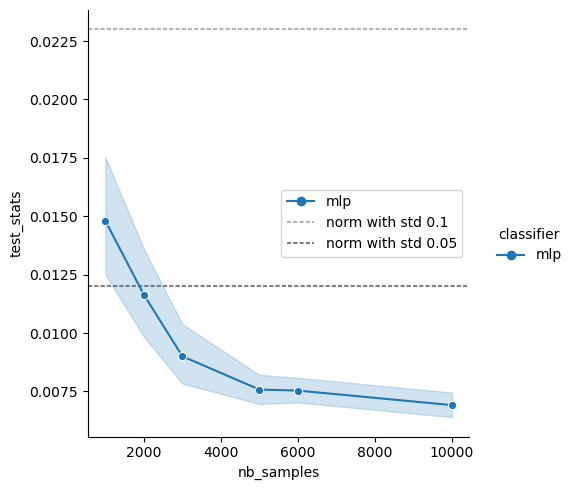

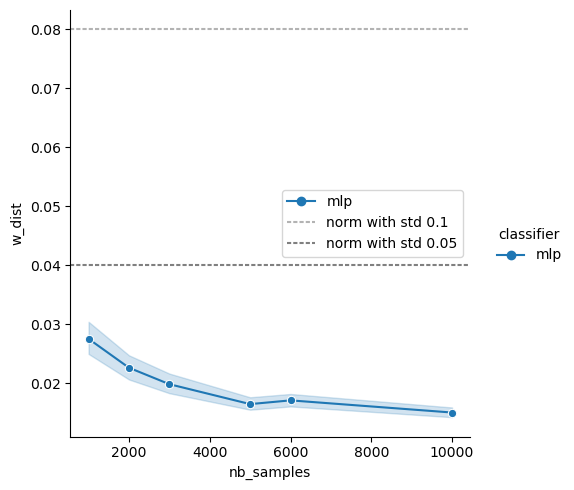

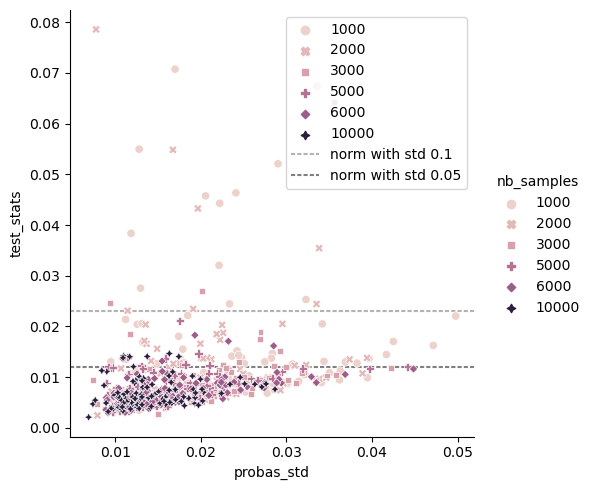

0.049785141859752094 0.044852519054413294


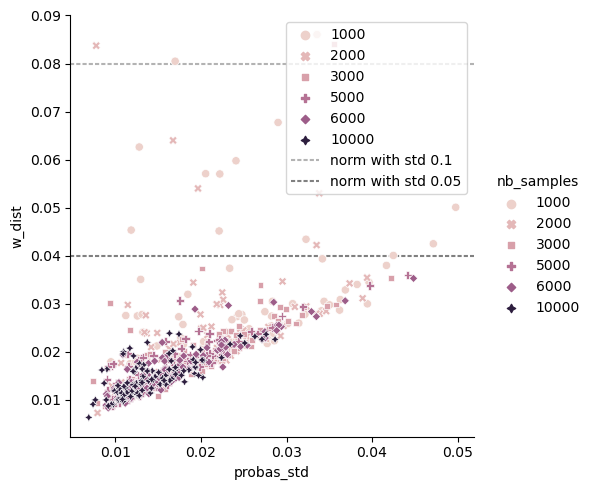

0.049785141859752094 0.044852519054413294


In [60]:
import seaborn as sns

dfs = []
for n in N_LIST:
    dfs.append(torch.load(f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats_wdist.pkl'))

df = pd.concat(dfs, ignore_index=True)
for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()


for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    print(df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max())

Results:
- plot 1/2: the wanted theoretical test statistic value is obtained for a sample size of 2-3_000 (for 0.05 std) and always for 0.1 std. It is always obtained if the test statistic is the wasserstein distance.
- plot 3/4: Larger sample sizes ensure small test statistics for small stds (closer to theory). There are no data points that deviate from the theory (see printed max stds below plot that are respectively smaller than 0.1 and 0.05). The wasserstein distance is almost never above the theoretical one, compared to the c.d.f test-statistic. 

1. The wasserstein distance seems to lead to statistically more powerful tests (less data needed to get narrow confidence regions).

2. What sample size do we chose? The smallest to obtain a good accuracy curve in the shift-experiment AND test statistics below a chose theoretical reference gaussian (0.1 or 0.05 std). 

    We chose 5000 because it gave the smoothest and most precise curve in the scale-shift experiment. But looking at the above plots for the "total variation" test-statistic (distance between c.d.fs), we could also try a sample size of 2000-3000 (which is where we get to the theoretical value associated to the gaussian with 0.05 std).